In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
# Any results you write to the current directory are saved as output.

# Dataset loading using torchvision module

In [4]:
#image transformations for train and test data
im_size = 150
image_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=5),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.4302, 0.4575, 0.4539), (0.2361, 0.2347, 0.2432))])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.4302, 0.4575, 0.4539), (0.2361, 0.2347, 0.2432))])

#inverse normalization for image plot

inv_normalize =  transforms.Normalize(
    mean=[-0.4302/0.2361, -0.4575/0.2347, -0.4539/0.2432],
    std=[1/0.2361, 1/0.2347, 1/0.2432]
)

In [17]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = '../input/seg_train/seg_train', transform = image_transforms)
train_loader =  DataLoader(train_data, batch_size = 32 , shuffle = True)
test_data = torchvision.datasets.ImageFolder(root = '../input/seg_test/seg_test', transform = test_transforms)
test_loader =  DataLoader(test_data, batch_size = 32 , shuffle = True)
#label of classes
classes = train_data.classes
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

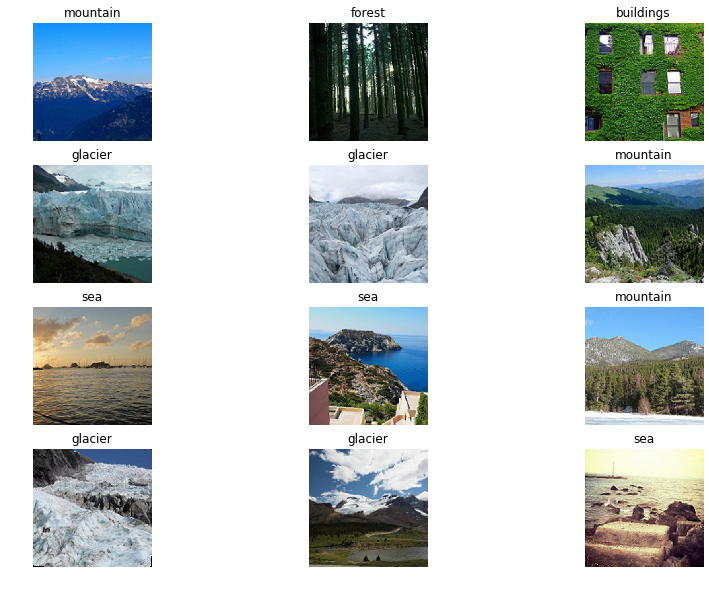

In [6]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(n_figures , data , encoder ,inv_normalize):
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        l = encoder[label]
        image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(12,train_data,encoder,inv_normalize)

In [ ]:
#uncomment to calculate mean of dataset and replace in normalize transform
'''mean = 0.
std = 0.
from tqdm import tqdm
nb_samples = len(data)
for data,_ in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
mean /= nb_samples
std /= nb_samples'''


# Declare model

In [15]:
!pip install torchsummary
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
#using resnet 34 model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = models.resnet34(pretrained = True)
        self.num_ftrs = self.resnet.fc.in_features
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.5)
        self.l2 = nn.Linear(256,6)
        self.relu = nn.ReLU()
        self.soft = nn.LogSoftmax(dim=1)
    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        
        x = self.soft(self.l2(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)
#uncomment to see summary of the created model
summary(classifier,(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [8]:
import torch.optim as optim
# Loss -> Negative log likelihood loss
criterion = nn.NLLLoss()

#lr scheduler ->
#learning rate half after 3 epochs
# cyclical learning rate ->
#Original learning rate restored after 10 epochs

In [12]:
def train(epoch,dataloader,batch_size):
    losses = []
    accuracy = []
    lr = 0.0001
    for i in range(epoch):
        j=0
        running_corrects = 0
        running_loss=0
        optimizer = optim.Adam(classifier.parameters(), lr=lr)
        if(epoch%3==0):
            lr = lr/2
        if(epoch%10==0):
            lr = 0.0001
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = Variable(data), Variable(target)
            data = data.type(torch.cuda.FloatTensor)
            target = target.type(torch.cuda.LongTensor)
            optimizer.zero_grad()
            output = classifier(data)
            loss = criterion(output, target)
            _, preds = torch.max(output, 1)
            #print(preds.shape)
            loss.backward()
            optimizer.step()
            #print(target.shape)
            running_corrects = running_corrects + torch.sum(preds == target.data)
            running_loss += loss.item() * data.size(0)
            j = j+1
            if batch_idx % 100 == 0:
                print('Train Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(i, batch_idx * len(data), len(dataloader.dataset),100. * batch_idx / len(dataloader)
                                                                                             , running_loss/(j*32),running_corrects.double()/(j*32)))
        epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
        epoch_loss = running_loss/(len(dataloader)*batch_size)
        losses.append(epoch_loss)
        accuracy.append(epoch_acc)
        print(epoch_acc)
    return losses,accuracy

In [16]:
loss1,accuracy1 = train(20,train_loader,32)

Train Epoch: 0  [0/14034 (0%)]	Loss: 2.187211 	Acc: 0.062500
Train Epoch: 0  [3200/14034 (23%)]	Loss: 0.467829 	Acc: 0.834777
Train Epoch: 0  [6400/14034 (46%)]	Loss: 0.403097 	Acc: 0.859919
Train Epoch: 0  [9600/14034 (68%)]	Loss: 0.371365 	Acc: 0.871885
Train Epoch: 0  [12800/14034 (91%)]	Loss: 0.345636 	Acc: 0.881780
tensor(0.8834, device='cuda:0', dtype=torch.float64)
Train Epoch: 1  [0/14034 (0%)]	Loss: 0.182202 	Acc: 0.937500
Train Epoch: 1  [3200/14034 (23%)]	Loss: 0.254673 	Acc: 0.912438
Train Epoch: 1  [6400/14034 (46%)]	Loss: 0.256262 	Acc: 0.914024
Train Epoch: 1  [9600/14034 (68%)]	Loss: 0.260393 	Acc: 0.913517
Train Epoch: 1  [12800/14034 (91%)]	Loss: 0.254307 	Acc: 0.914822
tensor(0.9144, device='cuda:0', dtype=torch.float64)
Train Epoch: 2  [0/14034 (0%)]	Loss: 0.260990 	Acc: 0.875000
Train Epoch: 2  [3200/14034 (23%)]	Loss: 0.217764 	Acc: 0.916460
Train Epoch: 2  [6400/14034 (46%)]	Loss: 0.213769 	Acc: 0.923663
Train Epoch: 2  [9600/14034 (68%)]	Loss: 0.218708 	Acc: 0.9

In [18]:
#traning accuracy and error plot
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()


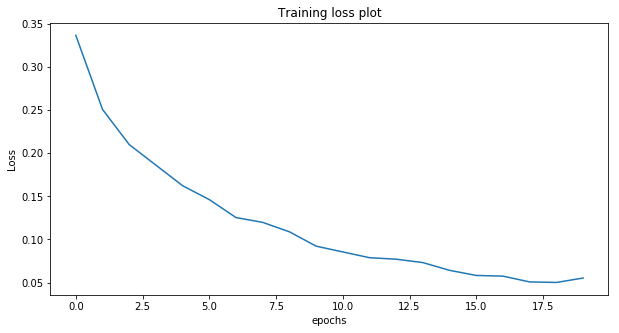

In [19]:
error_plot(loss1)

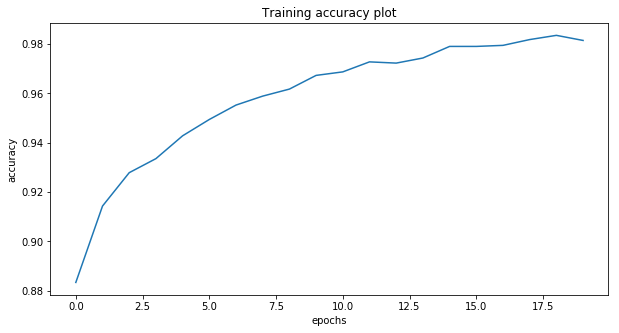

In [20]:
acc_plot(accuracy1)

In [21]:
batch_size = 32
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    image = []
    for batch_idx, (data, target) in enumerate(dataloader):
      data, target = Variable(data), Variable(target)
      data = data.type(torch.cuda.FloatTensor)
      target = target.type(torch.cuda.LongTensor)
      classifier.eval()
      output = classifier(data)
      _, preds = torch.max(output, 1)
      loss = criterion(output, target)
      running_corrects = running_corrects + torch.sum(preds == target.data)
      running_loss += loss.item() * data.size(0)
      preds = preds.cpu().numpy()
      target = target.cpu().numpy()
      preds = np.reshape(preds,(len(preds),1))
      target = np.reshape(target,(len(preds),1))
      data = data.cpu().numpy()
      for i in range(len(preds)):
        if(preds[i]!=target[i]):
          pred.append(preds[i])
          true.append(target[i])
          image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image
true,pred,image = test(test_loader)

tensor(0.8135, device='cuda:0', dtype=torch.float64) 1.614865891001326


In [22]:
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
  print('Classes in order correct and wrong')
  n_row = int(n_figures/3)
  fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
  for ax in axes.flatten():
    a = random.randint(0,len(true)-1)
    
    image,correct,wrong = ima[a],true[a],pred[a]
    image = torch.from_numpy(image)
    correct = int(correct)
    c = encoder[correct]
    wrong = int(wrong)
    w = encoder[wrong]
    f = c + ',' + w
    if inv_normalize !=None:
      image = inv_normalize(image)
    image = image.numpy().transpose(1,2,0)
    im = ax.imshow(image)
    ax.set_title(f)
    ax.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Classes in order correct and wrong


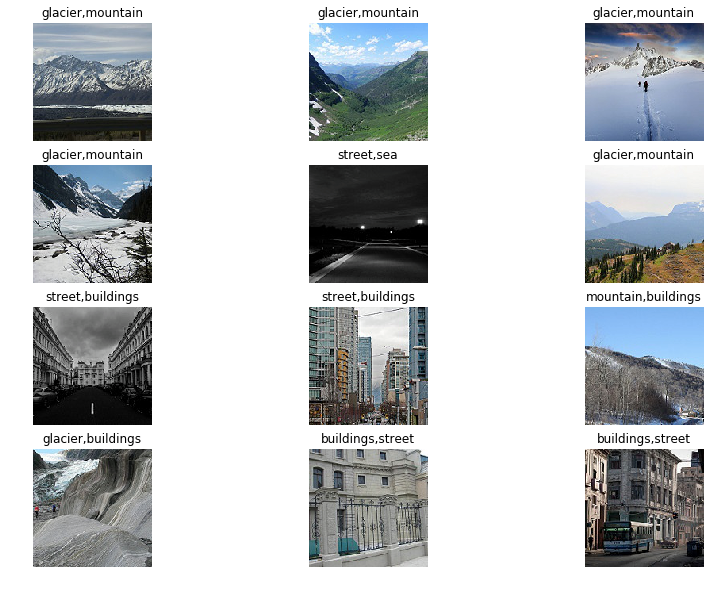

In [23]:
wrong_plot(12,true,image,pred,encoder,inv_normalize)